In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_path = '../LBLS160/data/'

In [4]:
br_pd = pd.read_csv(data_path + 'br.csv')
score_pd = pd.read_csv(data_path+'score.csv')
sill_pd = pd.read_csv(data_path+'sill.csv')
viscode_pd = pd.read_csv(data_path+'viscode.csv')
srl_m_pd = pd.read_csv(data_path+'srl_motivation.csv')

In [5]:
score_pd = score_pd.set_index('userid')
sill_pd = sill_pd.set_index('userid')
viscode_pd = viscode_pd.set_index('userid')
br_pd = br_pd.set_index('userid')
srl_m_pd = srl_m_pd.set_index('userid')

In [6]:
srl_m_pd = srl_m_pd[~srl_m_pd.index.duplicated()]

# merged_pd = pd.concat([br_pd, sill_pd, viscode_pd, score_pd], axis=1)
# merged_pd = pd.concat([br_pd, viscode_pd, srl_m_pd, sill_pd, score_pd], axis=1)
# merged_pd = pd.concat([srl_m_pd, sill_pd, score_pd], axis=1)
merged_pd = pd.concat([srl_m_pd, br_pd, viscode_pd, score_pd], axis=1)
# merged_pd = merged_pd.drop(columns=['REGIST CONTENTS'])

merged_pd = merged_pd[merged_pd['score'].notna()]
merged_pd = merged_pd.fillna(0)

In [7]:
merged_pd['label']=1
merged_pd.loc[merged_pd['score'] > 83, 'label']=0
merged_pd.shape

(198, 85)

## 1-1 Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


target_class = 'a'
source_class = 'b'

test_list = merged_pd['class'].unique().tolist()
test_list.remove(target_class)

test_index = test_list.index(source_class)
test_index

0

In [9]:
train_df = merged_pd[merged_pd['class'] == target_class]
test_0_df = merged_pd[merged_pd['class'] == test_list[0]]
test_1_df = merged_pd[merged_pd['class'] == test_list[1]]
test_2_df = merged_pd[merged_pd['class'] == test_list[2]]

train_np = scaler.fit_transform(train_df.drop(['class', 'label', 'score'], axis=1))
test_0_np = scaler.transform(test_0_df.drop(['class', 'label', 'score'], axis=1))
test_1_np = scaler.transform(test_1_df.drop(['class', 'label', 'score'], axis=1))
test_2_np = scaler.transform(test_2_df.drop(['class', 'label', 'score'], axis=1))

In [10]:
# convert from np to df, for feature selection

train_y = train_df['label']
test_0_y = test_0_df['label']
test_1_y = test_1_df['label']
test_2_y = test_2_df['label']

feature_list = list(train_df.drop(['class', 'label', 'score'], axis=1))

train_x_df = pd.DataFrame(train_np, columns = feature_list, index=train_df.index)
test_0_x_df = pd.DataFrame(test_0_np, columns = feature_list, index=test_0_df.index)
test_1_x_df = pd.DataFrame(test_1_np, columns = feature_list, index=test_1_df.index)
test_2_x_df = pd.DataFrame(test_2_np, columns = feature_list, index=test_2_df.index)

## 1-2 Feature Selection

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [12]:
selector = SelectKBest(score_func=chi2, k=15)

In [13]:
x_new = selector.fit_transform(train_x_df, 
                               train_y)

filter = selector.get_support()

features = np.array(list(train_x_df))

selected_features = list(features[filter])
selected_features

['srl_m_17',
 'srl_m_19',
 'srl_m_22',
 'srl_m_23',
 'srl_m_24',
 'srl_m_25',
 'srl_m_26',
 'ADD MEMO',
 'CHANGE MEMO',
 'DELETE MARKER',
 'NOTGETIT',
 'PAGE_JUMP',
 'code_copy',
 'FileNotFoundError',
 'ModuleNotFoundError']

In [14]:
merged_pd = merged_pd[selected_features]

In [15]:
train_x_df = train_x_df[selected_features]

test_0_x_df = test_0_x_df[selected_features]
test_1_x_df = test_1_x_df[selected_features]
test_2_x_df = test_2_x_df[selected_features]

## 1-3 Basic PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=3)

In [18]:
pca.fit(train_x_df)
train_x_pca_np = pca.transform(train_x_df)
test_0_x_pca_np = pca.transform(test_0_x_df)
test_1_x_pca_np = pca.transform(test_1_x_df)
test_2_x_pca_np = pca.transform(test_2_x_df)

In [19]:
train_pca_pd = pd.DataFrame(train_x_pca_np, index=train_x_df.index)
train_pca_pd['label'] = train_y

test_0_pca_pd = pd.DataFrame(test_0_x_pca_np, index=test_0_df.index)
test_0_pca_pd['label'] = test_0_y

test_1_pca_pd = pd.DataFrame(test_1_x_pca_np, index=test_1_df.index)
test_1_pca_pd['label'] = test_1_y

test_2_pca_pd = pd.DataFrame(test_2_x_pca_np, index=test_2_df.index)
test_2_pca_pd['label'] = test_2_y

# Setup Target and Source

In [20]:
source_x_np = train_pca_pd.drop(['label'], axis=1).values
source_y_np = train_pca_pd['label'].values


# print(global()['test_'+str(test_index)+'_pca_pd'])

target_x_np = globals()['test_'+str(test_index)+'_pca_pd'].drop(['label'], axis=1).values
target_y_np = globals()['test_'+str(test_index)+'_pca_pd']['label'].values

# DAPCA

In [21]:
from DAPCA import DAPCA

In [22]:
dapca = PCA(svd_solver='full')
u = dapca.fit_transform(source_x_np)

In [23]:
alpha = 1
num_comps = 2
gamma = 150
maxIter = 20
beta = 100
kNN = 30

In [24]:
initialV = dapca.components_[:num_comps,:].T
if num_comps==1:
    initialV = initialV.reshape(-1,1)
    

[V1, D1, source_dapca_x, target_dapca_x, kNNs] = DAPCA(source_x_np, source_y_np, num_comps,  YY=target_x_np, 
                                                       alpha=alpha, gamma=gamma,maxIter=maxIter,
                                                       beta=beta,verbose='all',kNN=kNN,
                                                       initialV = initialV,eps=1e-10)                                    


Iteration: 0 non-neg: 1 Hw: 5.6827089260386465
Iteration: 1 non-neg: 1 Hw diff: 0.09491607328049448 (6.278654120657889)
Iteration: 2 non-neg: 1 Hw diff: 0.05474279671880214 (6.642270589278014)
Iteration: 3 non-neg: 1 Hw diff: 0.01696882266052115 (6.7569276971000685)
Iteration: 4 non-neg: 1 Hw diff: 0.004256828272667632 (6.785813740885326)
Iteration: 5 non-neg: 1 Hw diff: 0.0007046077445760926 (6.790598449142898)
Iteration: 6 non-neg: 1 Hw diff: 0.00038762143822948926 (6.793231651365827)
Iteration: 7 non-neg: 1 Hw diff: 0.000399429052717366 (6.795946149698719)
Iteration: 8 non-neg: 1 Hw diff: 4.651908994919533e-05 (6.796262305636233)
Iteration: 9 non-neg: 1 Hw diff: 1.2713769984799069e-05 (6.796348712850505)
Iteration: 10 non-neg: 1 Hw diff: 1.6428518881992958e-05 (6.796460368628002)
Iteration: 11 non-neg: 1 Hw diff: 0.00014366735366770663 (6.797436938404665)
Iteration: 12 non-neg: 1 Hw diff: 1.0078254762468409e-05 (6.797505445396293)
Iteration: 13 non-neg: 1 Hw diff: 0.0 (6.79750544539

/tf/DAPCA/DAPCA.py:618: UserWarning: All eigenvalues starting from 1 are negative
  warnings.warn(f"All eigenvalues starting from {ind} are negative")


In [25]:
# source

source_dapca_pd = pd.DataFrame(source_dapca_x)
source_dapca_pd['label'] = source_y_np

In [26]:
target_dapca_pd = pd.DataFrame(target_dapca_x)
target_dapca_pd['label'] = target_y_np

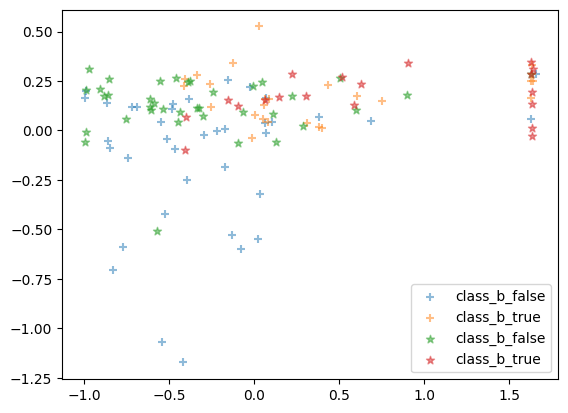

In [27]:
plt.scatter(x = source_dapca_pd[source_dapca_pd['label']==0][0], 
            y = source_dapca_pd[source_dapca_pd['label']==0][1],
            label = 'class_'+test_list[0] + '_false',
            alpha=0.5, marker="+")

plt.scatter(x = source_dapca_pd[source_dapca_pd['label']==1][0], 
            y = source_dapca_pd[source_dapca_pd['label']==1][1],
            label = 'class_'+test_list[0] + '_true',
            alpha=0.5, marker="+")

plt.scatter(x = target_dapca_pd[target_dapca_pd['label']==0][0], 
            y = target_dapca_pd[target_dapca_pd['label']==0][1],
            label = 'class_'+test_list[0] + '_false',
            alpha=0.5, marker="*")

plt.scatter(x = target_dapca_pd[target_dapca_pd['label']==1][0], 
            y = target_dapca_pd[target_dapca_pd['label']==1][1],
            label = 'class_'+test_list[0] + '_true',
            alpha=0.5, marker="*")

plt.legend()
plt.show()

# SVM Evaluation

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(source_dapca_x, 
                                                    source_y_np, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [29]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [30]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571

In [31]:
y_pred = clf.predict(target_dapca_x)
accuracy_score(target_y_np, y_pred)

0.7857142857142857

# Visualization

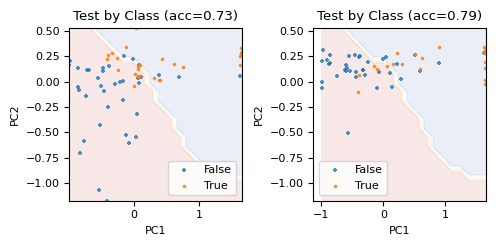

In [32]:
resolution = 20
dx = np.linspace(np.min(source_dapca_x[:, 0]), np.max(source_dapca_x[:, 0]), resolution)
dy = np.linspace(np.min(source_dapca_x[:, 1]), np.max(source_dapca_x[:, 1]), resolution)
dx, dy = np.meshgrid(dx, dy)


# merge dx, dy to test_x
test_x = np.c_[dx.flatten(), dy.flatten()]
z = clf.predict(test_x)
z = z.reshape(dx.shape)

plt.rcParams.update({'font.size': 8})
plt.subplots(figsize=(5, 2.5))

for i in range(0, 2):

    plt.subplot(1, 2, i+1)
    plt.contourf(dx, dy, z, alpha=0.1, cmap='RdYlBu')
    
    if i == 0:
        label = 'source'
    else:
        label = 'target'
    
    # source_dapca_pd
    scatter_x = globals()[label+'_dapca_pd']
    
    # source_dapca_x, source_y_np
    predict_x = globals()[label+'_dapca_x']
    predict_y = globals()[label+'_y_np']
    
    y_pred = clf.predict(predict_x)
    acc = accuracy_score(predict_y, y_pred)

    plt.scatter(x = scatter_x[scatter_x['label']==0][0], 
                y = scatter_x[scatter_x['label']==0][1],
                label = 'False',
                alpha=0.8, marker="+", s=10)

    plt.scatter(x = scatter_x[scatter_x['label']==1][0], 
                y = scatter_x[scatter_x['label']==1][1],
                label = 'True',
                alpha=0.8, marker=".", s=10)
    
    plt.ylabel('PC2')
    plt.xlabel('PC1')
        
    plt.legend()
    plt.title('Test by Class (acc=' +"{:.2f}".format(acc)+')')

    
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [33]:
import itertools

import warnings
warnings.filterwarnings('ignore')

In [34]:
alphas = list(np.arange (1, 10, 1))
num_comps = 2
gammas = list(np.arange (1, 10, 1))
maxIter = 20
betas = list(np.arange (1, 10, 1))
kNNs = list(range(1, 30, 1))

accuracy = 0

for alpha, gamma, beta, kNN in list(itertools.product(alphas, gammas, betas, kNNs)):

    initialV = dapca.components_[:num_comps,:].T
    if num_comps==1:
        initialV = initialV.reshape(-1,1)


    [V1, D1, source_dapca_x, target_dapca_x, kNNs] = DAPCA(source_x_np, source_y_np, num_comps,  YY=target_x_np, 
                                                           alpha=alpha, gamma=gamma,maxIter=maxIter,
                                                           beta=beta,verbose='warning',kNN=kNN,
                                                           initialV = initialV, eps=1e-10)   

    source_dapca_pd = pd.DataFrame(source_dapca_x)
    source_dapca_pd['label'] = source_y_np

    target_dapca_pd = pd.DataFrame(target_dapca_x)
    target_dapca_pd['label'] = target_y_np

    X_train, X_test, y_train, y_test = train_test_split(source_dapca_x, 
                                                        source_y_np, 
                                                        test_size=0.33, 
                                                        random_state=42)

    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(target_dapca_x)
    acc = accuracy_score(target_y_np, y_pred)
    
    if acc > accuracy:
        accuracy = acc
        print (accuracy, alpha, gamma, beta, kNN)
        
        opt_model = clf
        opt_alpha = alpha
        opt_gamma = gamma
        opt_beta = beta
        opt_kNN = kNN


0.7857142857142857 1 1 1 1
0.8035714285714286 1 1 2 1


KeyboardInterrupt: 

In [35]:
initialV = dapca.components_[:num_comps,:].T
if num_comps==1:
    initialV = initialV.reshape(-1,1)
    

[V1, D1, source_dapca_x, target_dapca_x, kNNs] = DAPCA(source_x_np, source_y_np, num_comps,  YY=target_x_np, 
                                                       alpha=opt_alpha, gamma=opt_gamma, maxIter=maxIter,
                                                       beta=opt_beta, verbose='all', kNN=opt_kNN,
                                                       initialV = initialV,eps=1e-10)

source_dapca_pd = pd.DataFrame(source_dapca_x)
source_dapca_pd['label'] = source_y_np

target_dapca_pd = pd.DataFrame(target_dapca_x)
target_dapca_pd['label'] = target_y_np

X_train, X_test, y_train, y_test = train_test_split(source_dapca_x, 
                                                    source_y_np, 
                                                    test_size=0.33, 
                                                    random_state=42)

Iteration: 0 non-neg: 2 Hw: 1.9243562215382326
Iteration: 1 non-neg: 2 Hw diff: 0.0034481886629670767 (1.9310147246196887)
Iteration: 2 non-neg: 2 Hw diff: 0.0025273820584277677 (1.935907502508304)
Iteration: 3 non-neg: 2 Hw diff: 0.002075279222160896 (1.9399334059981477)
Iteration: 4 non-neg: 2 Hw diff: 0.0013415256591435753 (1.9425393724101325)
Iteration: 5 non-neg: 2 Hw diff: 0.001029150641282629 (1.9445405976131662)
Iteration: 6 non-neg: 2 Hw diff: 0.00023041384619758854 (1.9449887499518537)
Iteration: 7 non-neg: 2 Hw diff: 1.716871050006726e-05 (1.9450221434739512)
Iteration: 8 non-neg: 2 Hw diff: 4.591448011249292e-05 (1.9451114522550423)
Iteration: 9 non-neg: 2 Hw diff: 4.618772727732657e-06 (1.9451204363242658)


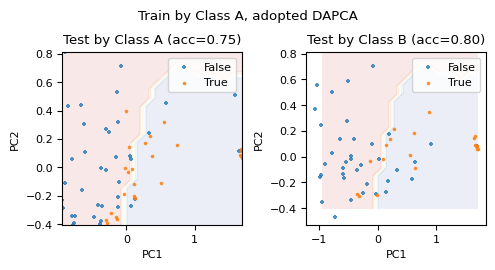

In [36]:
resolution = 20
dx = np.linspace(np.min(source_dapca_x[:, 0]), np.max(source_dapca_x[:, 0]), resolution)
dy = np.linspace(np.min(source_dapca_x[:, 1]), np.max(source_dapca_x[:, 1]), resolution)
dx, dy = np.meshgrid(dx, dy)


# merge dx, dy to test_x
test_x = np.c_[dx.flatten(), dy.flatten()]
z = opt_model.predict(test_x)
z = z.reshape(dx.shape)

plt.rcParams.update({'font.size': 8})
plt.subplots(figsize=(5, 2.5))

for i in range(0, 2):

    plt.subplot(1, 2, i+1)
    plt.contourf(dx, dy, z, alpha=0.1, cmap='RdYlBu')
    
    
    if i == 0:
        label = 'source'
        Class = target_class
    else:
        label = 'target'
        Class = source_class
    
   
    # source_dapca_pd
    scatter_x = globals()[label+'_dapca_pd']
    
    # source_dapca_x, source_y_np
    predict_x = globals()[label+'_dapca_x']
    predict_y = globals()[label+'_y_np']
    

    
    y_pred = opt_model.predict(predict_x)
    acc = accuracy_score(predict_y, y_pred)

    plt.scatter(x = scatter_x[scatter_x['label']==0][0], 
                y = scatter_x[scatter_x['label']==0][1],
                label = 'False',
                alpha=0.8, marker="+", s=10)

    plt.scatter(x = scatter_x[scatter_x['label']==1][0], 
                y = scatter_x[scatter_x['label']==1][1],
                label = 'True',
                alpha=0.8, marker=".", s=10)
    
    plt.ylabel('PC2')
    plt.xlabel('PC1')
        
    plt.legend()
    plt.title('Test by Class '+ Class.upper() + ' (acc=' +"{:.2f}".format(acc)+')')

plt.tight_layout()
plt.suptitle("Train by Class " + target_class.upper() + ', adopted DAPCA', y=1.05)
plt.show()